In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import random
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from time import time
import seaborn as sns

%matplotlib inline

In [2]:
train_data = pd.read_csv("train.csv", low_memory=False)
test_data = pd.read_csv("test.csv", low_memory=False)
store_data = pd.read_csv("store.csv")
train_data['Date'] = pd.to_datetime(train_data['Date'])
test_data['Date'] = pd.to_datetime(test_data['Date'])

In [3]:
# left join two dataset based on Store (Id)
train_data = train_data.merge(store_data, on='Store', how='left')
test_data = test_data.merge(store_data, on='Store', how='left')

#train_data.to_csv("merged_train.csv")
#test_data.to_csv("merged_test.csv")

# Exploratory Data Analysis

In [4]:
train_data.dtypes 

Store                                 int64
DayOfWeek                             int64
Date                         datetime64[ns]
Sales                                 int64
Customers                             int64
Open                                  int64
Promo                                 int64
StateHoliday                         object
SchoolHoliday                         int64
StoreType                            object
Assortment                           object
CompetitionDistance                 float64
CompetitionOpenSinceMonth           float64
CompetitionOpenSinceYear            float64
Promo2                                int64
Promo2SinceWeek                     float64
Promo2SinceYear                     float64
PromoInterval                        object
dtype: object

In [21]:
train_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [5]:
print("Number of training data: {}".format(len(train_data.Store)))
print("Number of test data: {}".format(len(test_data.Store)))

Number of training data: 1017209
Number of test data: 41088


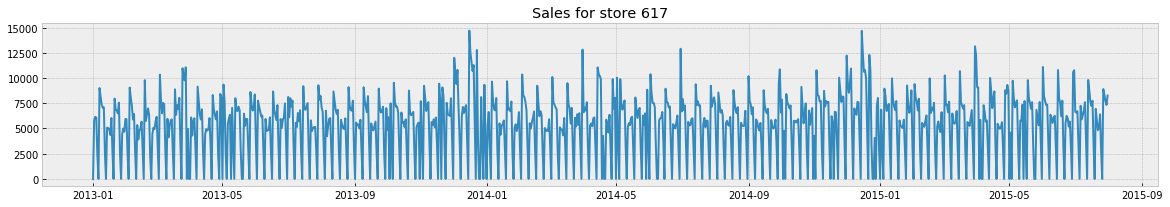

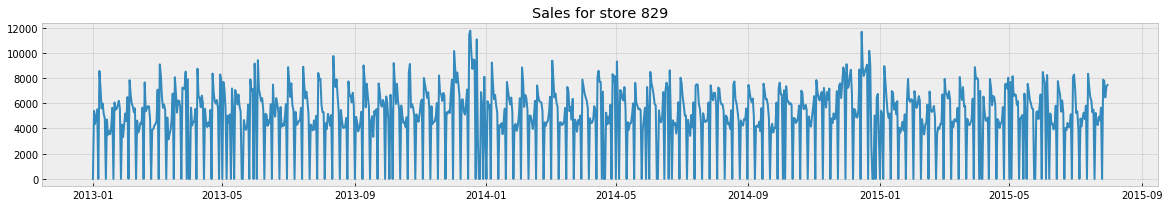

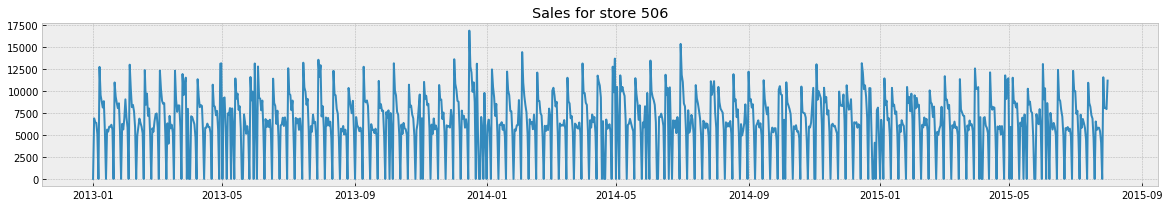

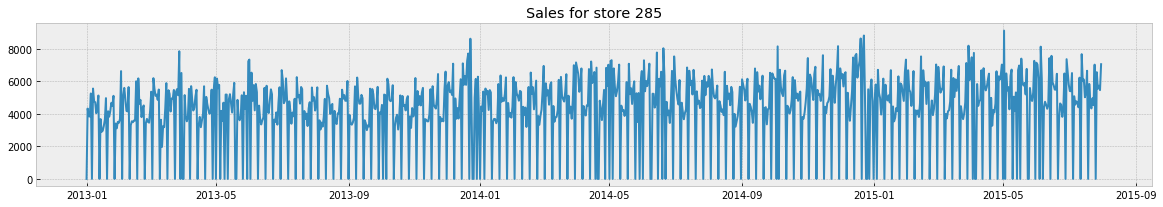

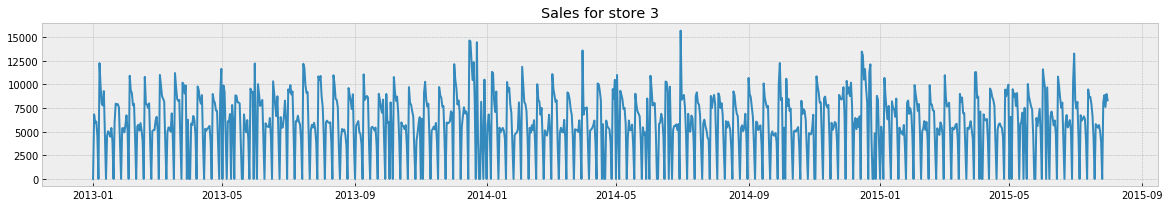

In [5]:
# select a few random stores and visualize its sales
stores = np.random.choice(train_data['Store'], 5, replace=False)

for store in stores:
    data = train_data.loc[train_data['Store'] == store]
    plt.figure(figsize=(20,3))
    plt.plot(data['Date'],data['Sales'])
    plt.title("Sales for store {}".format(store))
    plt.show()
    
# 6 month missing data is an error in data set up by Rossmann
# https://www.kaggle.com/c/rossmann-store-sales/discussion/17048#96947

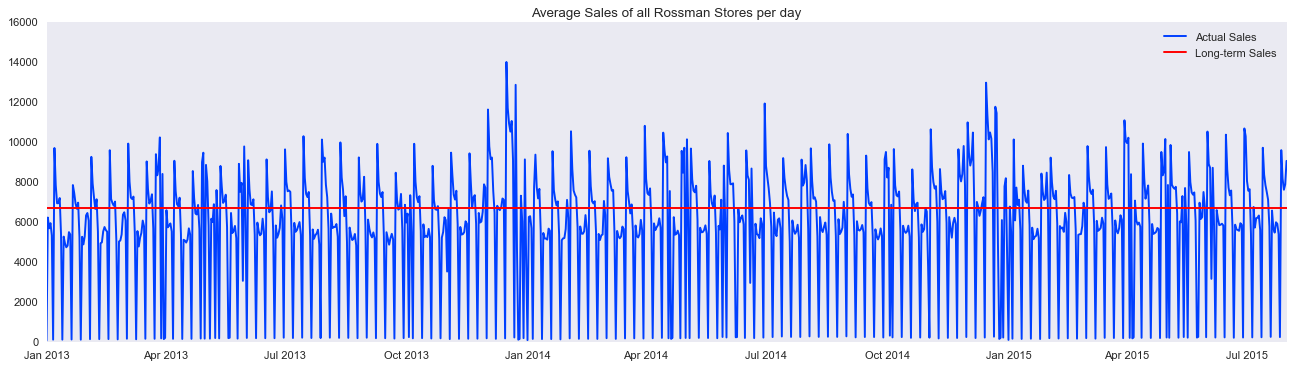

In [47]:
daily_mean = train_data.set_index('Date').groupby(pd.Grouper(freq='d')).mean().dropna(how='all')

plt.style.use('seaborn-dark')

plt.figure(figsize=(20,5))
plt.plot(daily_mean.index, daily_mean['Sales'], label='Actual Sales')
plt.axhline(y=6700, color='red', label='Long-term Sales')
plt.legend()
plt.title("Average Sales of all Rossman Stores per day")
plt.show()

# notice spike 

Spikes occur before January of each year (possibly due to Christmas).
And dips on New Years.
Average sales did not indicate positive trend (i.e. overall sales growth). 
Seasonality seems pretty consistent every year.

In [8]:
# check NaNs per column
print(train_data.isna().sum())

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64


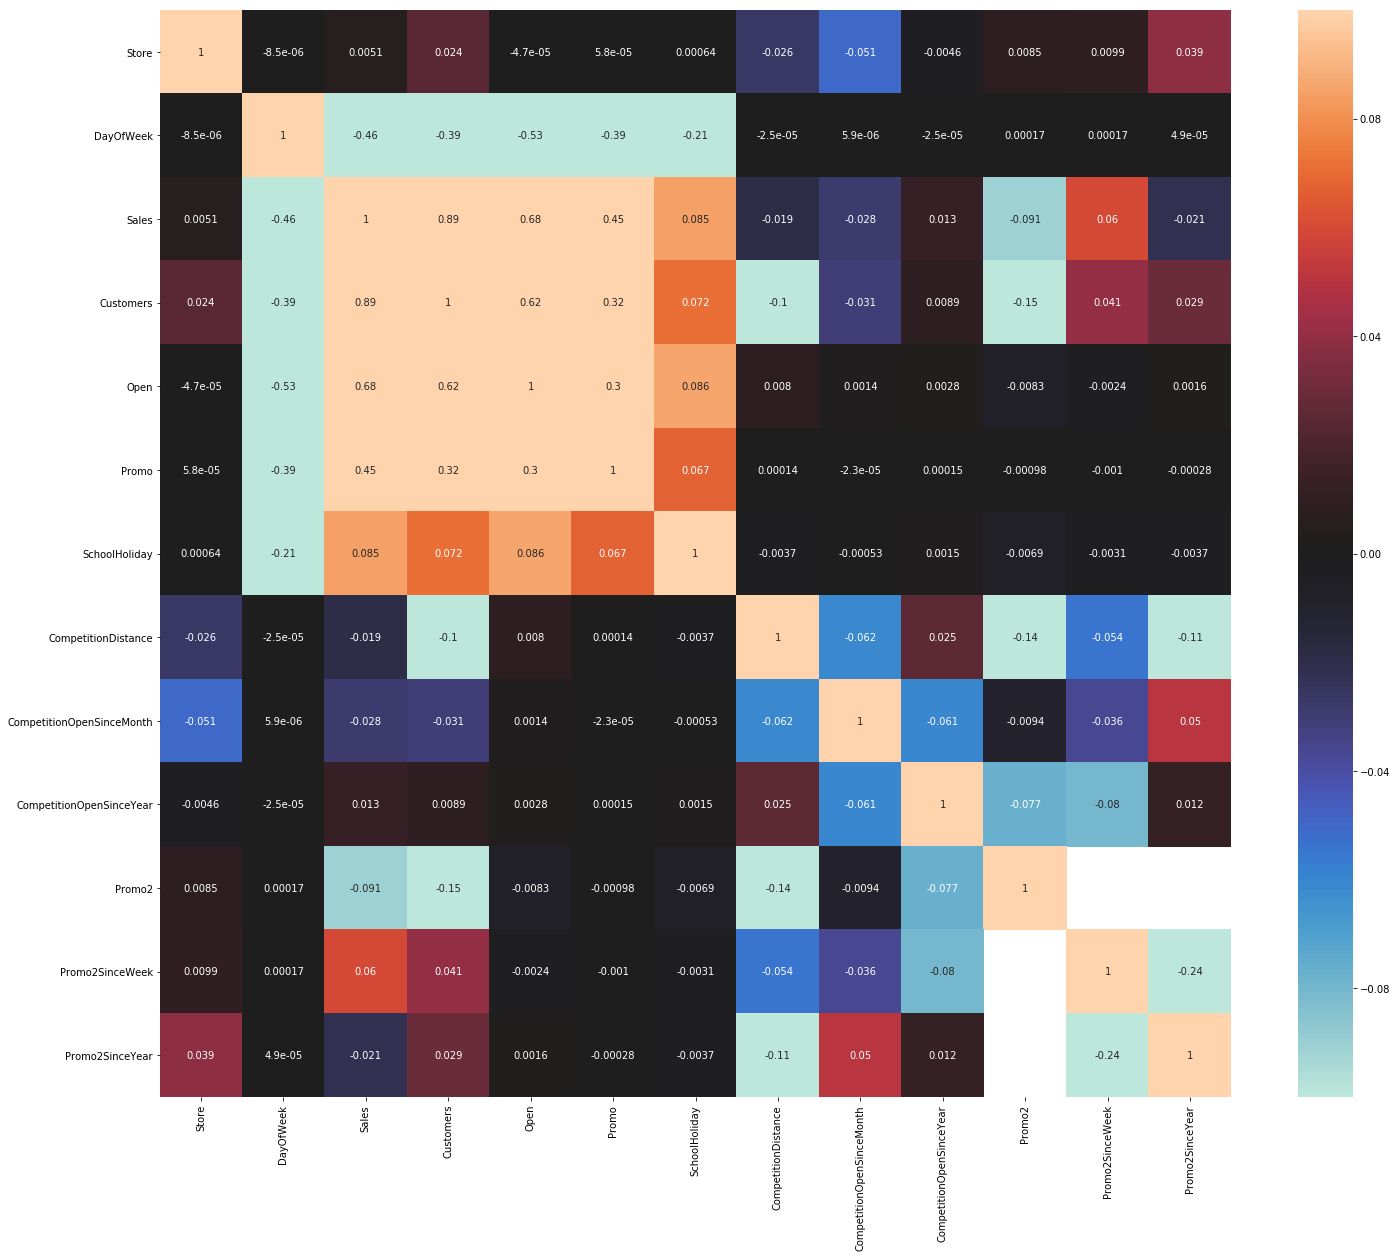

In [9]:
# the heat map of feature-feature and feature-label correlation 
plt.subplots(figsize=(24,20))
sns.heatmap(train_data.corr(),annot=True, vmin=-0.1, vmax=0.1,center=0)
plt.show()

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose

time_series_dat = train_data.copy()

def get_store(store_id, df=time_series_dat):
    """
    input:  
        store_id: (id of store from pandas dataframe)
        df: (pandas dataframe)
    For a given store, return the daily sales formated for prophet
    output: (store data)
    """
    store = df[df.Store == store_id][['Date', 'Sales']]
    store = store.rename(columns={'Date': 'ds','Sales': 'y'}).sort_values('ds')
    return store

store1017 = get_store(1017).set_index('ds')
#decomposition = seasonal_decompose(store, model='multiplicative', freq=365)

,y
ds,
2013-01-01,0
2013-01-02,7046
2013-01-03,6629
2013-01-04,6303
2013-01-05,5501
2013-01-06,0
2013-01-07,9507
2013-01-08,8870
2013-01-09,8168


# Data Pre-processing and Feature Engineering

## Training Data

In [15]:
# impute missing values if True, drop the column if False
impute_NAs = True

# feature engineer Competition Open and Promo information if True, drop if False
# CompetitionDistance, CompetitionOpenSinceMonth, CompetitionOpenSinceYear,
# Promo2SinceWeek, Promo2SinceYear, PromoInterval
feat_engineering = True

In [16]:
if impute_NAs:
    # fill missing values for CompetitionDistance with training data means
    # these are stores 291, 622 & 879
    test_data['CompetitionDistance'] = test_data['CompetitionDistance'].fillna(value=train_data['CompetitionDistance'].mean())
    train_data['CompetitionDistance'] = train_data['CompetitionDistance'].fillna(value=train_data['CompetitionDistance'].mean())
    
else:
    test_data = test_data.drop(['CompetitionDistance'],axis=1)
    train_data = train_data.drop(['CompetitionDistance'],axis=1)

In [17]:
def feat_engineer(data):
    # processing competition open to create a feature
    # competition duration
    data['year'] = data['CompetitionOpenSinceYear']
    data['month'] = data['CompetitionOpenSinceMonth']
    data['CompetitionOpen'] = pd.to_datetime(data.assign(day=1)[['year','month','day']])

    # calculate competition open duration in months
    data['CompetitionDuration'] = 12 * (data.Date.dt.year - data.CompetitionOpen.dt.year) + \
    (data.Date.dt.month - data.CompetitionOpen.dt.month)

    # for missing values, assume competition duration = 0
    data['CompetitionDuration'] = data['CompetitionDuration'].fillna(value = 0)

    # replace negative values with 0, negative duration doesn't make sense
    data['CompetitionDuration'] = data['CompetitionDuration'].mask(data['CompetitionDuration'].lt(0),0)
    data['CompetitionDuration'] = data['CompetitionDuration'].astype(int)

    # repeat for Promo2
    data['Promo2Start'] = pd.to_datetime(data.Promo2SinceYear.astype(str), format='%Y.0') + \
        pd.to_timedelta(data.Promo2SinceWeek.mul(7), unit='days')

    # calculate Promo2 duration in months
    data['Promo2Duration'] = 12 * (data.Date.dt.year - data.Promo2Start.dt.year) + \
    (data.Date.dt.month - data.Promo2Start.dt.month)

    # for missing values, assume Promo2 duration = 0
    data['Promo2Duration'] = data['Promo2Duration'].fillna(value = 0)

    # replace negative values with 0, negative duration doesn't make sense
    data['Promo2Duration'] = data['Promo2Duration'].mask(data['Promo2Duration'].lt(0),0)

    data['Promo2Duration'] = data['Promo2Duration'].astype(int)

    # drop columns that are not needed
    data = data.drop(['Promo2SinceWeek','Promo2SinceYear','Promo2Start','year','month',
                      'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'CompetitionOpen'],axis=1)

    # PromoInterval column looked like
    # NaN
    # Jan,Apr,Jul,Oct...

    # Here we convert them to dummy variables
    promo_interval = data.pop('PromoInterval').str.get_dummies(',')
    promo_interval.columns = ['PromoInterval_' + str(col) for col in promo_interval.columns]

    data = data.join(promo_interval)
    
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)
       
    return(data)

In [18]:
if feat_engineering:
    train_data = feat_engineer(train_data)
    test_data = feat_engineer(test_data)
    
else:
    train_data = train_data.drop(['CompetitionOpenSinceYear','CompetitionOpenSinceMonth','Promo2SinceWeek','Promo2SinceYear',
                    'PromoInterval'],axis=1)
    test_data = test_data.drop(['CompetitionOpenSinceYear','CompetitionOpenSinceMonth','Promo2SinceWeek','Promo2SinceYear',
                    'PromoInterval'],axis=1)

In [19]:
def preprocess(data):
    data['Year'] = data['Date'].dt.year
    data['Month'] = data['Date'].dt.month
    data['Day'] = data['Date'].dt.day
    data['WeekOfYear'] = data['Date'].dt.weekofyear

    # get dummies
    data = pd.get_dummies(data, columns=['DayOfWeek', 'StateHoliday','StoreType','Assortment'])    
    
    return(data)

train_data = preprocess(train_data)
test_data = preprocess(test_data)

In [21]:
train_data.head()

,Store,Date,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,Promo2,CompetitionDuration,...,StateHoliday_1,StateHoliday_2,StateHoliday_3,StoreType_1,StoreType_2,StoreType_3,StoreType_4,Assortment_1,Assortment_2,Assortment_3
0,1,2015-07-31,5263,555,1,1,1,1270.0,0,82,...,0,0,0,0,0,1,0,1,0,0
1,2,2015-07-31,6064,625,1,1,1,570.0,1,92,...,0,0,0,1,0,0,0,1,0,0
2,3,2015-07-31,8314,821,1,1,1,14130.0,1,103,...,0,0,0,1,0,0,0,1,0,0
3,4,2015-07-31,13995,1498,1,1,1,620.0,0,70,...,0,0,0,0,0,1,0,0,0,1
4,5,2015-07-31,4822,559,1,1,1,29910.0,0,3,...,0,0,0,1,0,0,0,1,0,0


In [22]:
Y_train = train_data['Sales']

train_data = train_data.drop(['Customers'],axis=1)
test_data = test_data.drop(['Id'],axis=1)

train = train_data.sort_values(['Date'],ascending = False)
train_data = train_data.drop(['Sales'],axis=1)

train_data = train_data.drop(columns=['Date'],axis=1)
test_data = test_data.drop(columns=['Date'],axis=1)

# code below from XGBoost https://www.kaggle.com/xwxw2929/rossmann-sales-top1
# split the last 6 weeks data as hold-out set (idea from Gert https://www.kaggle.com/c/rossmann-store-sales/discussion/18024)
ho_test = train[:6*7*1115]
ho_train = train[6*7*1115:]

ho_test = ho_test[ho_test["Open"] != 0]
ho_test = ho_test[ho_test["Sales"] > 0]
ho_train = ho_train[ho_train["Open"] != 0]
ho_train = ho_train[ho_train["Sales"] > 0]

In [23]:
ho_ytrain = np.log1p(ho_train.Sales)
ho_ytest = np.log1p(ho_test.Sales)

ho_train = ho_train.drop(columns=['Date','Sales'],axis=1)
ho_test = ho_test.drop(columns=['Date','Sales'],axis=1)

In [24]:
def fill_missing_cols(train_data, test_data):
    # Get missing columns in the test set
    missing_cols = set(train_data.columns) - set(test_data.columns)

    # Add a missing column in test set with default value equal to 0
    for c in missing_cols:
        test_data[c] = 0
    # Ensure the order of column in the test set is in the same order than in train set
    test_data = test_data[train_data.columns]
    
    return(test_data)

test_data = fill_missing_cols(train_data, test_data)
ho_test = fill_missing_cols(ho_train, ho_test)

In [25]:
def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)

params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.03,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 10
          }

num_boost_round = 100

dtrain = xgb.DMatrix(ho_train, ho_ytrain)
dvalid = xgb.DMatrix(ho_test, ho_ytest)
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

#模型训练
print("Train a XGBoost model")
start = time()
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, 
  early_stopping_rounds=30, feval=rmspe_xg, verbose_eval=True)
end = time()
print('Training time is {:2f} s.'.format(end-start))

#采用保留数据集进行检测
print("validating")
ho_test.sort_index(inplace=True) 
ho_ytest.sort_index(inplace=True) 
yhat = gbm.predict(xgb.DMatrix(ho_test))
error = rmspe(np.expm1(ho_ytest), np.expm1(yhat))

print('RMSPE: {:.6f}'.format(error))

/Users/franklooi/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Train a XGBoost model
[0]	train-rmse:8.02088	eval-rmse:8.02689	train-rmspe:0.999808	eval-rmspe:0.999811
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 30 rounds.
[1]	train-rmse:7.78076	eval-rmse:7.78759	train-rmspe:0.99971	eval-rmspe:0.999714
[2]	train-rmse:7.5478	eval-rmse:7.55494	train-rmspe:0.99959	eval-rmspe:0.999595
[3]	train-rmse:7.32178	eval-rmse:7.32923	train-rmspe:0.999444	eval-rmspe:0.999451
[4]	train-rmse:7.10269	eval-rmse:7.11043	train-rmspe:0.999266	eval-rmspe:0.999276
[5]	train-rmse:6.8901	eval-rmse:6.89794	train-rmspe:0.999053	eval-rmspe:0.999065
[6]	train-rmse:6.68406	eval-rmse:6.69221	train-rmspe:0.998798	eval-rmspe:0.998814
[7]	train-rmse:6.48412	eval-rmse:6.49254	train-rmspe:0.998495	eval-rmspe:0.998516
[8]	train-rmse:6.29016	eval-rmse:6.29862	train-rmspe:0.998138	eval-rmspe:0.998164
[9]	train-rmse:6.10204	eval-rmse:6.11044	train-rmspe:0.99772	eval-rmspe:0.997752
[10]	train-rmse:5.

[97]	train-rmse:0.499945	eval-rmse:0.501416	train-rmspe:0.384124	eval-rmspe:0.373048
[98]	train-rmse:0.489199	eval-rmse:0.490704	train-rmspe:0.37852	eval-rmspe:0.366989
[99]	train-rmse:0.478971	eval-rmse:0.480037	train-rmspe:0.373193	eval-rmspe:0.360932
Training time is 360.798211 s.
validating
RMSPE: 0.360932


In [55]:
dtest = xgb.DMatrix(test_data)
preds = gbm.predict(dtest)

In [48]:
X_train = train_data

def run_model(model):
    model = model()
    model = model.fit(X_train, Y_train)
    preds = model.predict(test_data)
    return(preds)

preds = run_model(RandomForestRegressor)

/Users/franklooi/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [56]:
np.savetxt("submission_XGB_FE.csv", np.dstack((np.arange(1, preds.size+1),preds))[0],\
           "%d,%f",header="Id,Sales",comments="")

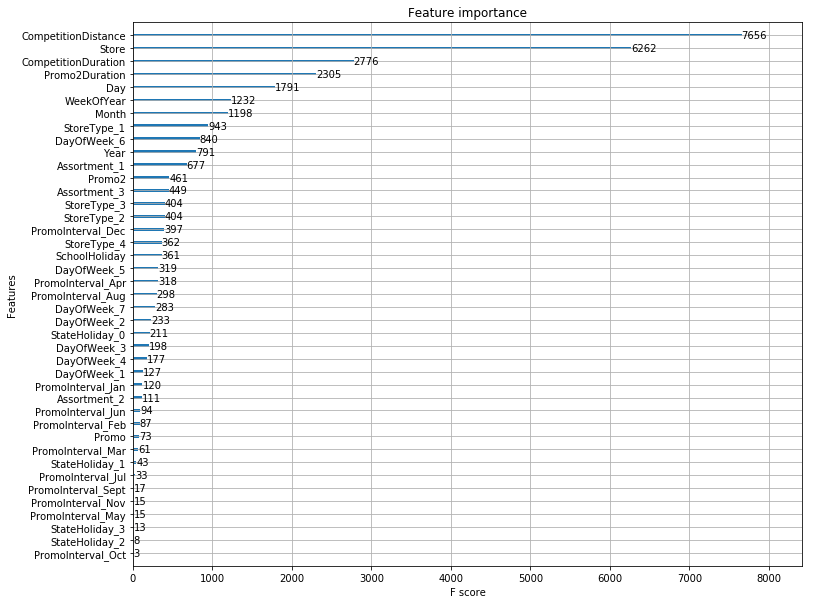

In [33]:
ax = xgb.plot_importance(gbm)
fig = ax.figure
fig.set_size_inches(12, 10)

# Dump